In [14]:
%pip install torchshow

Note: you may need to restart the kernel to use updated packages.


torch.Size([3, 50, 88])

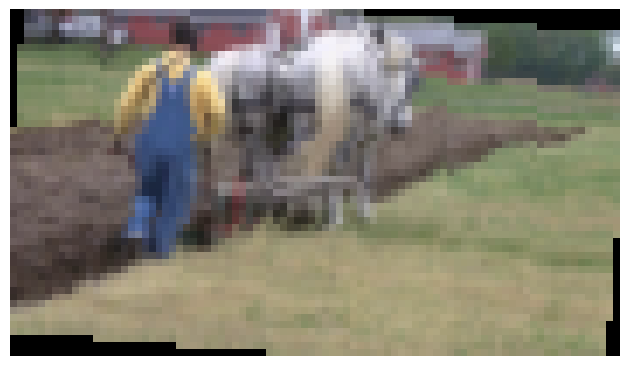

In [58]:
import torch
import pandas as pd
import numpy as np
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torchshow as ts

# класс для поддержки датасетов, где ответы (labels) хранятся в файле csv а не в названиях папок
class CustomDataset(Dataset):
    def __init__(self, image_dir, answers_file=None, transform=None, mode="train"):
        self.image_dir = image_dir
        self.mode = mode
        if self.mode == "train":
            self.answers_df = pd.read_csv(answers_file)
        self.transform = transform
    
    def __len__(self):
        return len(os.listdir(self.image_dir))
    
    def __getitem__(self, index):
        filename = str(self.answers_df.iloc[index, 0]) + ".jpg" if self.mode == "train" else list(os.walk(self.image_dir))[0][2][index]
        img_name = os.path.join(self.image_dir, filename)
        image = Image.open(img_name)
        
        if self.transform:
            image = self.transform(image)
        if self.mode == "train":
            label = self.answers_df.iloc[index, 1]
            return image, label
        filename_index = int(filename.split(".")[0])
        return image, filename_index

downscale_mult = .85 # 15% обрезки по краям
transform = transforms.Compose([
    transforms.CenterCrop([int(720 * downscale_mult), int(1280 * downscale_mult)]),
    transforms.Resize(50),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    #transforms.Normalize([0.25], [0.25]),
])

basefolder = "" # локально поставьте пустую строку

dataset_train = CustomDataset(f"{basefolder}human_poses_data/img_train", f'{basefolder}human_poses_data/train_answers.csv', transform=transform)
image_shape = dataset_train[0][0].shape
ts.show(dataset_train[145][0])
image_shape

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [17]:
from torch import nn
from torchinfo import summary



# чтобы сделать модель со skip-connection, нужно добавить класс блока с ним
class BasicBlockWithSkip(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(BasicBlockWithSkip, self).__init__()

    self.block = nn.Sequential(
        # bias=False, т.к. есть батч нормы
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(out_channels)
    )

    self.shortcut = nn.Sequential(
        # bias=False, т.к. есть батч нормы
        nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
        nn.BatchNorm2d(out_channels)
    )

  def forward(self, x):
    return nn.ReLU()(self.block(x) + self.shortcut(x))

model = nn.Sequential(
    BasicBlockWithSkip(3, 16),
    nn.MaxPool2d(2, 2),

    BasicBlockWithSkip(16, 64),
    nn.MaxPool2d(2, 2),

    BasicBlockWithSkip(64, 128),
    nn.MaxPool2d(2, 2),

    nn.Flatten(),
    nn.Linear(8448, 500),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(500, 20),
    #nn.Softmax(dim=1)
)

#model = nn.Sequential(
#  nn.Flatten(),
#  nn.Linear(np.prod(image_shape), 5000),
#  nn.ReLU(),
#  nn.Dropout(p=0.2),
#  nn.Linear(5000, 2500),
#  nn.ReLU(),
#  nn.Dropout(p=0.2),
#  nn.Linear(2500, 20),
#  nn.Softmax(dim=1)
#)

# выводим summary модели
summary(model, [1] + list(image_shape))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 20]                   --
├─BasicBlockWithSkip: 1-1                [1, 16, 50, 88]           --
│    └─Sequential: 2-1                   [1, 16, 50, 88]           --
│    │    └─Conv2d: 3-1                  [1, 16, 50, 88]           432
│    │    └─BatchNorm2d: 3-2             [1, 16, 50, 88]           32
│    │    └─ReLU: 3-3                    [1, 16, 50, 88]           --
│    │    └─Conv2d: 3-4                  [1, 16, 50, 88]           2,304
│    │    └─BatchNorm2d: 3-5             [1, 16, 50, 88]           32
│    └─Sequential: 2-2                   [1, 16, 50, 88]           --
│    │    └─Conv2d: 3-6                  [1, 16, 50, 88]           48
│    │    └─BatchNorm2d: 3-7             [1, 16, 50, 88]           32
├─MaxPool2d: 1-2                         [1, 16, 25, 44]           --
├─BasicBlockWithSkip: 1-3                [1, 64, 25, 44]           --
│    └─Sequ

In [18]:
from torch.utils.data import random_split

# объявляем оптимайзер и лосс
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=.9)
criterion = nn.CrossEntropyLoss()

# гиперпараметр модели
BATCH_SIZE = 10

# делим на трейн и валидацию
train_set, valid_set = random_split(dataset_train, [0.9, 0.1])

# создаём лоадеры для теста и валидации
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE)
valid_loader = DataLoader(valid_set, batch_size=BATCH_SIZE)

In [19]:
# используем pytorch ignite вместо бойлерплейта в ванильном торче
from ignite.engine import create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, Fbeta, Precision, Recall

trainer = create_supervised_trainer(model, optimizer, criterion, device)

precision = Precision(average=False)
recall = Recall(average=False)

metrics = {
    "accuracy": Accuracy(),
    "loss": Loss(criterion),
    "f1": Fbeta(beta=1.0, average=True, precision=precision, recall=recall)
}

train_evaluator = create_supervised_evaluator(model, metrics, device)
valid_evaluator = create_supervised_evaluator(model, metrics, device)

In [20]:
# логгинг, позаимствованный с семинара
from ignite.engine import Events

metrics_history = {"Train": [], "Valid": []}

def log_iter_loss(engine):
  print(f"EPOCH {engine.state.epoch} - Iter {engine.state.iteration}: loss = {engine.state.output}")

trainer.add_event_handler(Events.ITERATION_COMPLETED(every=100), log_iter_loss)

def compute_epoch_results(engine):
  train_evaluator.run(train_loader),
  valid_evaluator.run(valid_loader)

trainer.add_event_handler(Events.EPOCH_COMPLETED, compute_epoch_results)

def log_epoch_results(engine, label=""):
  print(f"[{label}]: {', '.join([f'{k}={v}' for k, v in engine.state.metrics.items()])}")
  metrics_history[label].append(list(engine.state.metrics.values()))

train_evaluator.add_event_handler(Events.EPOCH_COMPLETED, log_epoch_results, label="Train")
valid_evaluator.add_event_handler(Events.EPOCH_COMPLETED, log_epoch_results, label="Valid")

In [21]:
# добавляем динамическое уменьшение learning rate
from ignite.handlers.param_scheduler import ReduceLROnPlateauScheduler


scheduler = ReduceLROnPlateauScheduler(
    optimizer,
    metric_name="loss",
    factor=0.5, # уменьшить лр вдвое
    patience=2, # если последние 2 эпохи не было уменьшения лосса
    threshold=0.05 # на 0.05
)

def log_lr():
  for param_group in optimizer.param_groups:
    print(f"Learning rate: {param_group['lr']}")

valid_evaluator.add_event_handler(Events.COMPLETED, scheduler)
valid_evaluator.add_event_handler(Events.COMPLETED, log_lr)

In [22]:
# добавляем раннюю остановку
from ignite.handlers import EarlyStopping
early_stopping = EarlyStopping(patience=10, score_function=lambda engine: -criterion(*engine.state.output), trainer=trainer)
valid_evaluator.add_event_handler(Events.COMPLETED, early_stopping)
train_evaluator.add_event_handler(Events.COMPLETED, early_stopping)

In [23]:
from ignite.handlers import Checkpoint, DiskSaver

def create_checkpoint(trainer, model, optimizer):
    to_save = {
        "model": model,
        "optimizer": optimizer,
        "trainer": trainer,
        "early_stopping": early_stopping,
        "scheduler": scheduler
    }
    checkpoint_handler = Checkpoint(
        to_save,
        DiskSaver("submission-provitia-data", create_dir=True, require_empty=False),
        n_saved=5,
    )
    return checkpoint_handler

# Создаем чекпойнт обработчик
checkpoint_handler = create_checkpoint(trainer, model, optimizer)

# Добавляем обработчик на событие завершения эпохи
trainer.add_event_handler(Events.EPOCH_COMPLETED, checkpoint_handler)

In [24]:
if os.path.exists(f"{basefolder}submission-provitia-data/checkpoint_59042.pt"):
    checkpoint = torch.load(f"{basefolder}submission-provitia-data/checkpoint_59042.pt", weights_only=False)
    Checkpoint.load_objects(checkpoint=checkpoint, to_load={"model": model, "optimizer": optimizer, "trainer": trainer,
                                                            "early_stopping": early_stopping, "scheduler": scheduler})

In [ ]:
MAX_EPOCHS = 1
trainer.run(train_loader, max_epochs=MAX_EPOCHS)

ValueError: Argument max_epochs should be greater than or equal to the start epoch defined in the state: 1 vs 53. Please, set engine.state.max_epochs = None before calling engine.run() in order to restart the training from the beginning.

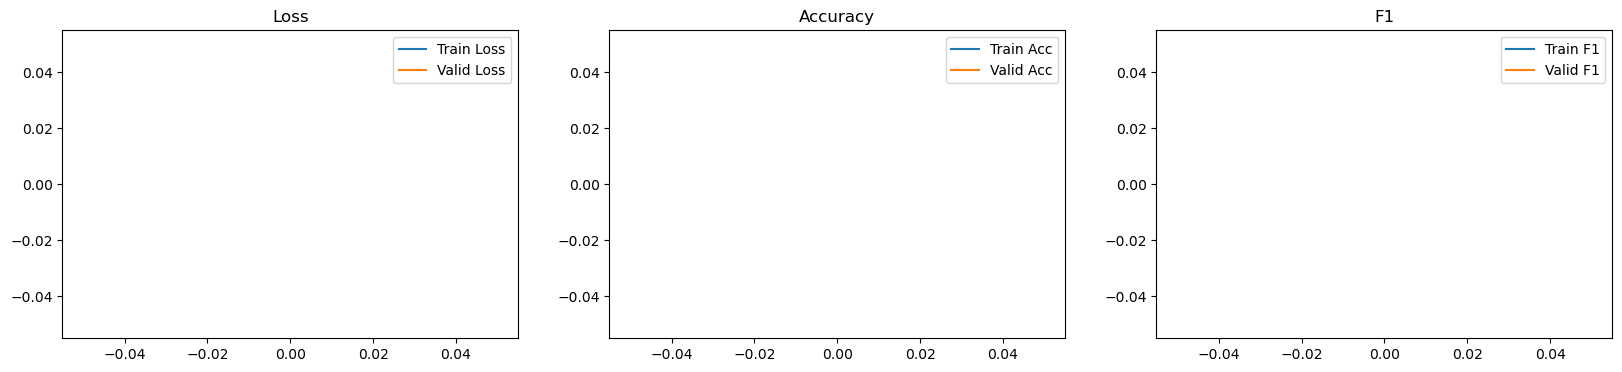

In [26]:
# изображаем изменения метрик в виде графика
import matplotlib.pyplot as plt


plt.figure(figsize=(20, 4))
plt.subplot(1, 3, 1)
plt.title("Loss")
losses = [[], []]
for k in metrics_history["Train"]:
  losses[0].append(k[1])
for k in metrics_history["Valid"]:
  losses[1].append(k[1])
r = range(1, len(losses[0])+1)
plt.plot(r, losses[0])
plt.plot(r, losses[1])
plt.legend(["Train Loss", "Valid Loss"])

plt.subplot(1, 3, 2)
plt.title("Accuracy")
accuracies = [[], []]
for k in metrics_history["Train"]:
  accuracies[0].append(k[0])
for k in metrics_history["Valid"]:
  accuracies[1].append(k[0])
plt.plot(r, accuracies[0])
plt.plot(r, accuracies[1])
plt.legend(["Train Acc", "Valid Acc"])

plt.subplot(1, 3, 3)
plt.title("F1")
f1_scores = [[], []]
for k in metrics_history["Train"]:
  f1_scores[0].append(k[2])
for k in metrics_history["Valid"]:
  f1_scores[1].append(k[2])
plt.plot(r, f1_scores[0])
plt.plot(r, f1_scores[1])
plt.legend(["Train F1", "Valid F1"])


plt.show()

In [ ]:
# тест
dataset_train = CustomDataset(f"{basefolder}human_poses_data/img_test", mode="test", transform=transform)
test_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE)

model.eval()
cols = ['id', 'target_feature']
answers = pd.DataFrame(columns=cols)

for batch in test_loader:
    pred = model(batch[0].to(device=device))
    pred = torch.argmax(pred, dim=1).detach()
    data = np.vstack([batch[1].numpy(), pred.cpu().numpy()]).T
    df = pd.DataFrame(data=data, columns=cols)
    if df['target_feature'].isna().sum() != 0:
        print(data)
        print(df)
        raise ValueError
    answers = pd.concat([answers, df])

outfolder = "" # локально пустая строка
answers.to_csv(f"{outfolder}submission.csv", index=False)
answers

,id,target_feature
0,0,8
1,100,5
2,10000,9
3,10003,9
4,10004,0
5,10007,12
6,10008,5
7,10009,3
8,10015,3
9,10016,3
